In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import re

In [39]:
random_state = 42

<h1> <span style="color: #CC5500;">1  |  </span> Data Loading and Preprocessing </h1>

In [40]:
# Load train dataset
df = pd.read_csv('ann-train.data', sep=' ', header=None)
df_test = pd.read_csv('ann-test.data', sep=' ', header=None)

# Drop unnecessary columns (last two)
df = df.drop(df.columns[-2:], axis=1)
df_test = df_test.drop(df_test.columns[-2:], axis=1)

# Create binary target (3 vs. non-3)
df['binary_target'] = df[21].apply(lambda x: 1 if x == 3 else 0)
df_test['binary_target'] = df_test[21].apply(lambda x: 1 if x == 3 else 0)

# Separate features (X) and target (y)
X_train = df.drop(['binary_target', 21], axis=1)
y_train_binary = df['binary_target']
y_train = df[21]
X_test = df_test.drop(['binary_target', 21], axis=1)
y_test_binary = df_test['binary_target']
y_test = df_test[21]

In [41]:
print("Class Distribution in Training Data:")
print(y_train.value_counts(normalize=True))
print("Class Distribution in Testing Data:")
print(y_test.value_counts(normalize=True))

Class Distribution in Training Data:
21
3    0.924708
2    0.050636
1    0.024655
Name: proportion, dtype: float64
Class Distribution in Testing Data:
21
3    0.927071
2    0.051634
1    0.021295
Name: proportion, dtype: float64


<h1> <span style="color: #CC5500;">2  |  </span> Binary Classification </h1>

In [42]:
binary_models = {}
multi_models = {}


def eval_binary(model, name):
    # Fit the classifier to the training data
    model.fit(X_train, y_train_binary)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Print classification report
    print(classification_report(y_test_binary, y_pred))
    binary_models[name] = classification_report(y_test_binary, y_pred, output_dict=True)
    # Print ROC AUC score
    print("ROC AUC:", roc_auc_score(y_test_binary, y_pred))
    # Print confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test_binary, y_pred, 
                                                   display_labels=["Not Healthy", "Healthy"],
                                                    cmap=plt.cm.Blues,
                                                    normalize='true')
    plt.title("Normalized Confusion Matrix (Binary Classification) for " + name)
    plt.show()
                                      

def eval_multi(model, name):
    #model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    print(classification_report(y_test, y_pred))
    multi_models[name] = classification_report(y_test, y_pred, output_dict=True)
    print("ROC AUC:", roc_auc_score(y_test, y_proba, multi_class='ovo'))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                            display_labels=["Hyper", "Hypo", "Normal"],
                                            cmap=plt.cm.Blues,
                                            normalize='true')
    plt.title("Normalized Confusion Matrix (Multi-Class Classification) for " + name)
    plt.show()

<h2> <span style="color: #CC5500;">2.1  |  </span> Simple SVM </h2>

              precision    recall  f1-score   support

           0       0.27      0.58      0.37       250
           1       0.96      0.87      0.92      3178

    accuracy                           0.85      3428
   macro avg       0.61      0.73      0.64      3428
weighted avg       0.91      0.85      0.88      3428

ROC AUC: 0.7285953429830083


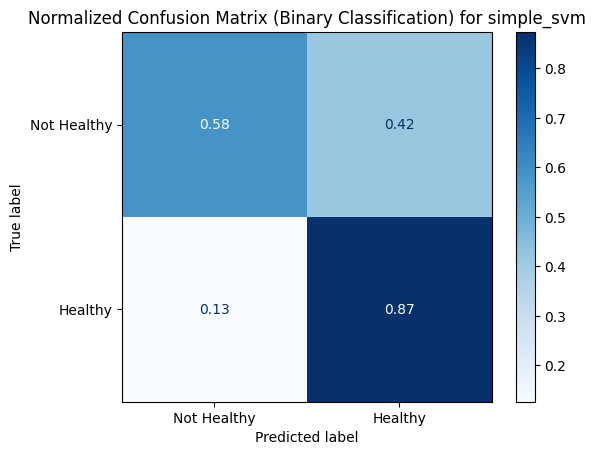

In [43]:
# Create a simple SVM classifier
svm_classifier = SVC(class_weight='balanced', probability=True, random_state=random_state)

# Evaluate the classifier
eval_binary(svm_classifier, "simple_svm")

<h2> <span style="color: #CC5500;">2.2  |  </span> Simple SVM with data scaling</h2>

<h3> <span style="color: #CC5500;">2.2.1  |  </span> Scaling all data</h3>

              precision    recall  f1-score   support

           0       0.64      0.90      0.75       250
           1       0.99      0.96      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.82      0.93      0.86      3428
weighted avg       0.97      0.96      0.96      3428

ROC AUC: 0.9283335431088736


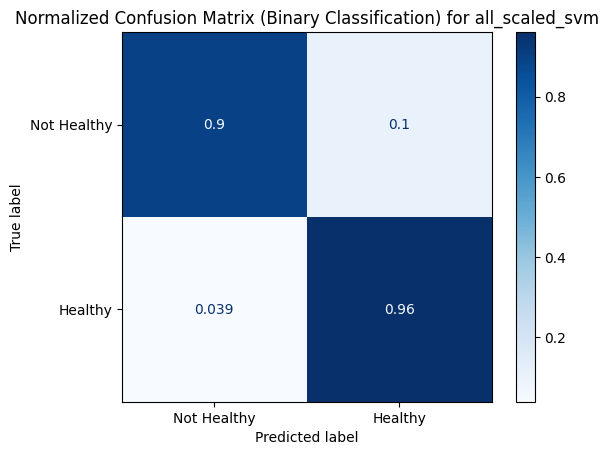

In [44]:
# Create a pipeline with scaling and SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=random_state))
])

eval_binary(pipeline_svm, "all_scaled_svm")

<h3> <span style="color: #CC5500;">2.2.2  |  </span> Scaling only continuous variables</h3>

              precision    recall  f1-score   support

           0       0.69      0.94      0.80       250
           1       1.00      0.97      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.84      0.96      0.89      3428
weighted avg       0.97      0.96      0.97      3428

ROC AUC: 0.9553228445563245


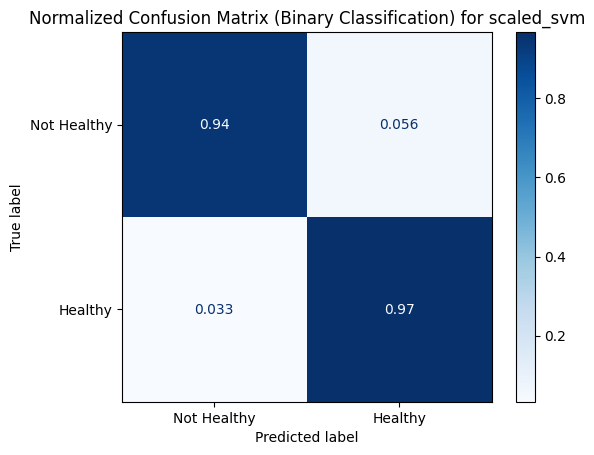

In [45]:
# Identify feature types
binary_cols = list(range(1, 16))
continuous_cols = list(range(16, 21)) + [0]

# Create a preprocessing transformer using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),  # Scale continuous features
        ('bin', 'passthrough', binary_cols),      # Keep binary features as is
    ]
)

pipeline_scale = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(class_weight='balanced', probability=True, random_state=random_state)),
])

eval_binary(pipeline_scale, "scaled_svm")

<h2> <span style="color: #CC5500;">2.3  |  </span> SVM with scaling and oversampling (SMOTE)</h2>

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       250
           1       1.00      0.97      0.99      3178

    accuracy                           0.97      3428
   macro avg       0.87      0.97      0.91      3428
weighted avg       0.98      0.97      0.97      3428

ROC AUC: 0.96725613593455


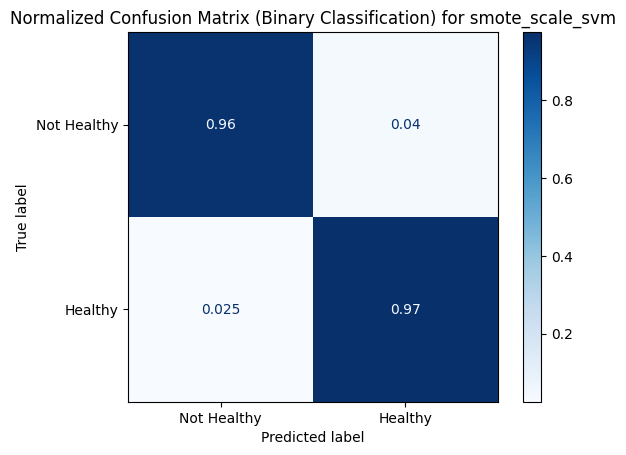

In [46]:
# Identify feature types
binary_cols = list(range(1, 16))
continuous_cols = list(range(16, 21)) + [0]

# Create a preprocessing transformer using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),  # Scale continuous features
        ('bin', 'passthrough', binary_cols),      # Keep binary features as is
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=random_state)),  # Oversample the minority class
    ('classifier', SVC(class_weight='balanced', probability=True, random_state=random_state)),
])

eval_binary(pipeline, "smote_scale_svm")

<h2> <span style="color: #CC5500;">2.3  |  </span> Using only useful features </h2>

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       250
           1       1.00      0.96      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.82      0.98      0.88      3428
weighted avg       0.97      0.96      0.96      3428

ROC AUC: 0.9758162366268093


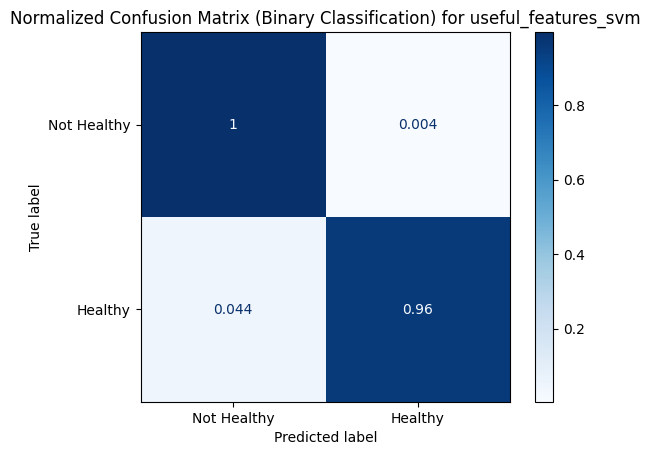

In [47]:
# Define most useful features for binary classification (found in dataset_exploration.ipynb)
useful_features = [1, 9, 15, 16, 17, 18, 20]

# Categorize features by type
useful_binary = [1, 9, 15]
useful_continuous = [16, 17, 18, 20]

# Extract only useful features
X_train_useful = X_train[useful_features]
X_test_useful = X_test[useful_features]

# Create a preprocessing transformer
useful_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), useful_continuous),  # Scale continuous features
        ('bin', 'passthrough', useful_binary),      # Keep binary features as is
    ]
)

# Create pipeline with preprocessing, SMOTE, and SVM
useful_pipeline = Pipeline([
    ('preprocessor', useful_preprocessor),
    ('smote', SMOTE(random_state=random_state)),
    ('classifier', SVC(class_weight='balanced', probability=True, random_state=random_state)),
])

# Evaluate the model
eval_binary(useful_pipeline, "useful_features_svm")

<h1> <span style="color: #CC5500;">3  |  </span> Multiclass Classification </h1>

<h2> <span style="color: #CC5500;">3.1  |  </span> Using all features </h2>

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'classifier__C': 1000, 'classifier__kernel': 'linear'}
Best CV score: 0.9047429873549606
              precision    recall  f1-score   support

           1       0.60      0.99      0.75        73
           2       0.77      0.99      0.86       177
           3       1.00      0.97      0.98      3178

    accuracy                           0.97      3428
   macro avg       0.79      0.98      0.86      3428
weighted avg       0.98      0.97      0.97      3428

ROC AUC: 0.9963677870946951


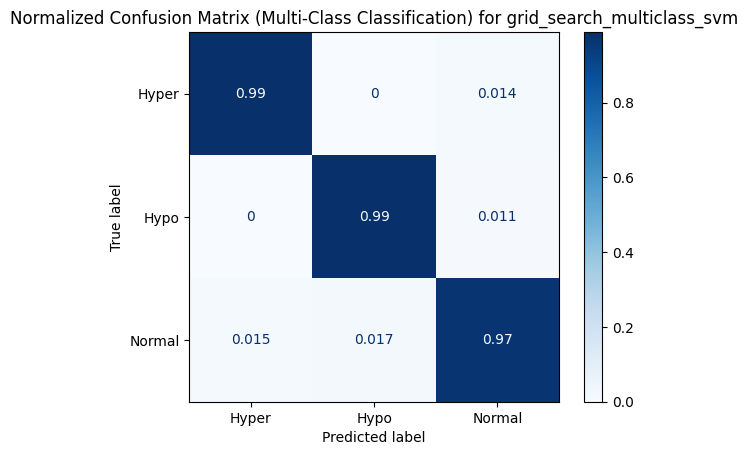

In [48]:
multi_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=random_state)),
    ('classifier', SVC(probability=True, random_state=random_state, decision_function_shape='ovo'))
])

# Parameter grid for SVM
# Parameter grid for SVM - using separate dictionaries for each kernel for efficiency
param_grid = [
    # RBF kernel parameters
    {
        'classifier__kernel': ['rbf'],
        'classifier__C': [10, 100, 1000, 10000],
        'classifier__gamma': ['scale', 'auto', 0.01]
    },
    # Polynomial kernel parameters
    {
        'classifier__kernel': ['poly'],
        'classifier__C': [10, 100, 1000, 10000],
        'classifier__degree': [2, 3, 4],
        'classifier__coef0': [0.0, 1.0]
    },
    # Linear kernel parameters
    {
        'classifier__kernel': ['linear'],
        'classifier__C': [10, 100, 1000, 2000]
    }
]

# Grid search with cross-validation
grid_search = GridSearchCV(
    multi_pipeline,
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=10,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
eval_multi(best_model, "grid_search_multiclass_svm")

<h2> <span style="color: #CC5500;">3.2  |  </span> Using important features </h2>

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters (useful features): {'classifier__C': 10000, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Best CV score (useful features): 0.9228380835290073
              precision    recall  f1-score   support

           1       0.78      0.88      0.83        73
           2       0.86      0.95      0.90       177
           3       0.99      0.99      0.99      3178

    accuracy                           0.98      3428
   macro avg       0.88      0.94      0.91      3428
weighted avg       0.98      0.98      0.98      3428

ROC AUC: 0.9950445419500507


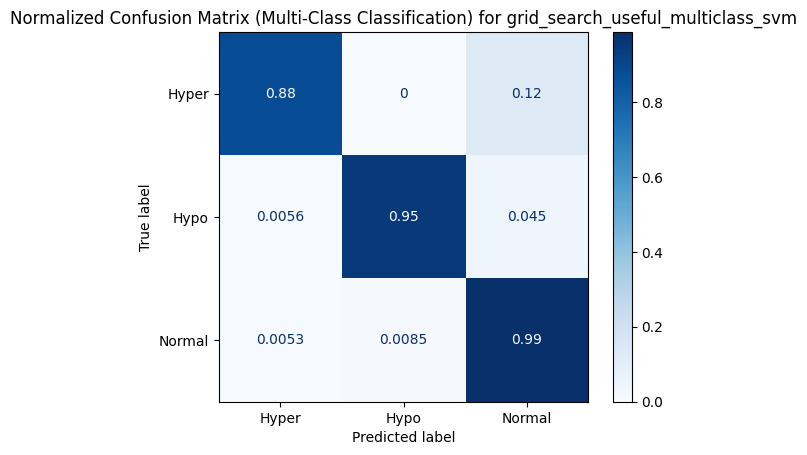

In [49]:
# Define most useful features for multiclass classification (found in dataset_exploration.ipynb)
useful_features = [1, 2, 5, 7, 9, 15, 16, 17, 18, 19, 20]

# Categorize features by type
useful_binary = [1, 2, 5, 7, 9, 15]
useful_continuous = [16, 17, 18, 19, 20]

# Create a preprocessing transformer
useful_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), useful_continuous),  # Scale continuous features
        ('bin', 'passthrough', useful_binary),      # Keep binary features as is
    ]
)

useful_multi_pipeline = Pipeline([
    ('preprocessor', useful_preprocessor),
    ('smote', SMOTE(random_state=random_state)),
    ('classifier', SVC(probability=True, random_state=random_state))
])

useful_grid_search = GridSearchCV(
    useful_multi_pipeline,
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

useful_grid_search.fit(X_train, y_train)

print("Best parameters (useful features):", useful_grid_search.best_params_)
print("Best CV score (useful features):", useful_grid_search.best_score_)

# Evaluate the best model
best_useful_model = useful_grid_search.best_estimator_
eval_multi(best_useful_model, "grid_search_useful_multiclass_svm")

<h1> <span style="color: #CC5500;">4  |  </span> Results </h1>

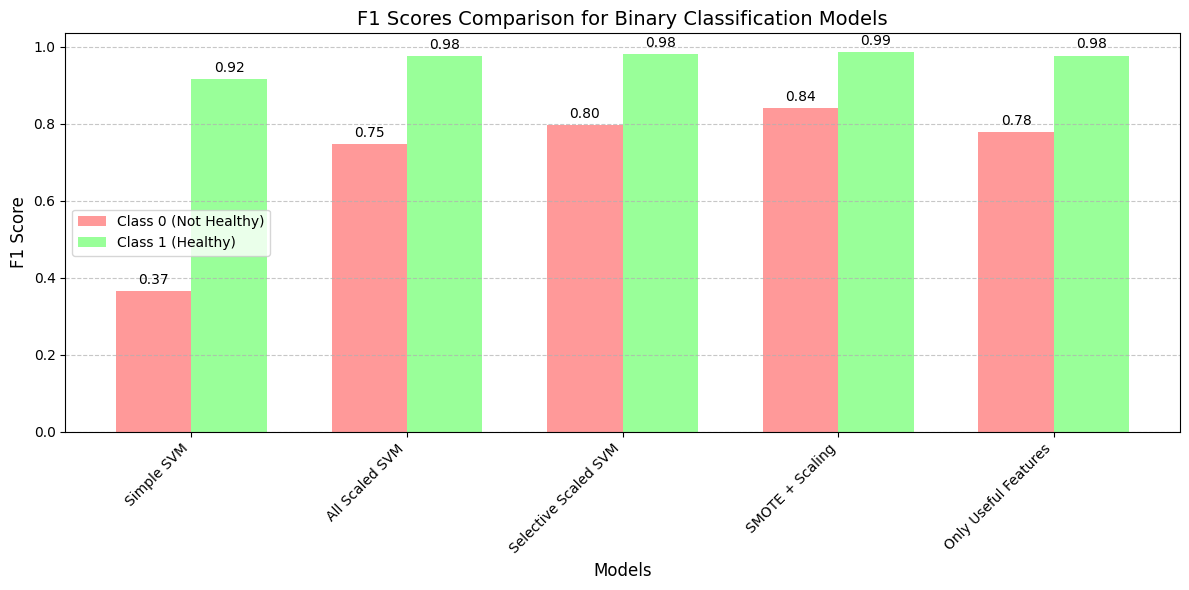

In [52]:
f1_scores = {}
for model_name, report in binary_models.items():
    f1_scores[model_name] = {
        'class_0': report['0']['f1-score'],
        'class_1': report['1']['f1-score']
    }

models = list(f1_scores.keys())
f1_class_0 = [f1_scores[model]['class_0'] for model in models]
f1_class_1 = [f1_scores[model]['class_1'] for model in models]

display_names = {
    'simple_svm': 'Simple SVM',
    'all_scaled_svm': 'All Scaled SVM',
    'scaled_svm': 'Selective Scaled SVM',
    'smote_scale_svm': 'SMOTE + Scaling',
    'useful_features_svm': 'Only Useful Features'
}
x_labels = [display_names.get(model, model) for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, f1_class_0, width, label='Class 0 (Not Healthy)', color='#ff9999')
rects2 = ax.bar(x + width/2, f1_class_1, width, label='Class 1 (Healthy)', color='#99ff99')

ax.set_ylabel('F1 Score', fontsize=12)
ax.set_xlabel('Models', fontsize=12)
ax.set_title('F1 Scores Comparison for Binary Classification Models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

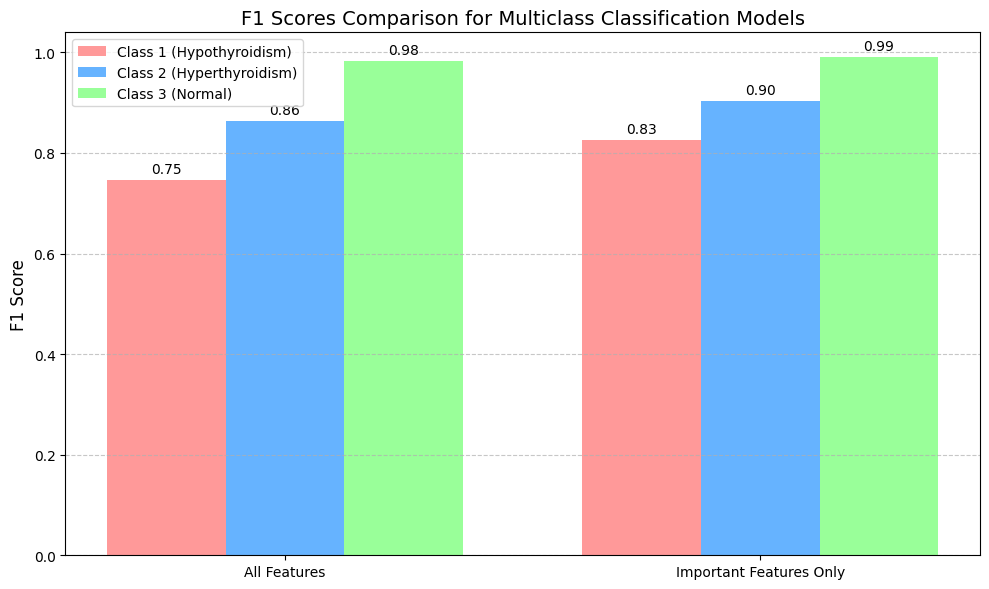

In [51]:
multi_f1_scores = {}
for model_name, report in multi_models.items():
    try:
        multi_f1_scores[model_name] = {
            'class_1': report['1']['f1-score'],  # Hypothyroidism
            'class_2': report['2']['f1-score'],  # Hyperthyroidism
            'class_3': report['3']['f1-score']   # Normal
        }
    except KeyError:
        print(f"Missing expected keys in report for {model_name}")

models = list(multi_f1_scores.keys())
f1_class_1 = [multi_f1_scores[model]['class_1'] for model in models]
f1_class_2 = [multi_f1_scores[model]['class_2'] for model in models]
f1_class_3 = [multi_f1_scores[model]['class_3'] for model in models]

display_names = {
    'grid_search_multiclass_svm': 'All Features',
    'grid_search_useful_multiclass_svm': 'Important Features Only'
}
x_labels = [display_names.get(model, model) for model in models]

# Create plot with grouped bars
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, f1_class_1, width, label='Class 1 (Hypothyroidism)', color='#ff9999')
rects2 = ax.bar(x, f1_class_2, width, label='Class 2 (Hyperthyroidism)', color='#66b3ff')
rects3 = ax.bar(x + width, f1_class_3, width, label='Class 3 (Normal)', color='#99ff99')

ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Scores Comparison for Multiclass Classification Models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.tight_layout()
plt.show()